In [1]:
model_comparison = dict()

In [2]:
from utils.supports import *
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm
from models.vae import VAE
from utils.codings import conv_celebA_enhanced_decoder
from utils.plot import *
from utils.path import getfiles
import re
import numpy as np
import tensorflow as tf
import tensorlayer as tl
import scipy
from scipy.stats import bernoulli
from scipy.stats import norm
from tensorflow.contrib.distributions import Normal
from PIL import *
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
LATENT_DIM = 100
OBS_DIM = 12288
BATCH_SIZE = 64
DECODER = conv_celebA_enhanced_decoder
WEIGHTS = 'weights/celebA/net.npz'
MASKED_DATA_SIZE = 5
MASKED_DATA_DROPOUT = [0.95, 0.85, 0.75]

In [4]:
class Faces(object):
    def __init__(self, image_folder=None, npy='data/celebA/faces.npy'):
        try:
            self.data = np.load(npy)
        except:
            self.data = self._get_data(image_folder)
            self.save_txt(npy)

    def _get_data(self, image_folder):
        print('here')
        image_names = getfiles(image_folder)

        images = []

        for image_name in tqdm(image_names):
            image = np.array(Image.open('{0}/{1}'.format(image_folder, image_name)))
            image = Faces.transform(image)
            images.append(image)

        images = np.array(images)

        return images
    
    @staticmethod
    def transform(image, npx=148, is_crop=True, resize_w=64):
        if is_crop:
            cropped_image = Faces.center_crop(image, npx, resize_w=resize_w)
        else:
            cropped_image = image
        return cropped_image/127.5 - 1. 
    
    @staticmethod
    def center_crop(x, crop_h, crop_w=None, resize_w=64):
        if crop_w is None:
            crop_w = crop_h # the width and height after cropped
        h, w = x.shape[:2]
        j = int(round((h - crop_h)/2.))
        i = int(round((w - crop_w)/2.))
        return scipy.misc.imresize(x[j:j+crop_h, i:i+crop_w],
                                   [resize_w, resize_w]) 

    def save_txt(self, path='data/celebA/faces.npy'):
        np.save(path, self.data)

    def get_size(self):
        return self.data.shape[0]

    def next_batch(self, num):
        '''
        Return a total of `num` random samples and labels.
        '''
        idx = np.arange(0, self.get_size())
        np.random.shuffle(idx)
        idx = idx[:num]
        batch = self.data[idx]

        return batch

In [5]:
faces = Faces('example_images/celebA_faces')

In [6]:
faces.save_txt()

In [7]:
def get_masked_faces(datasize, random_mask=False, dropout=0.9):
    provider = Faces()
    x = provider.next_batch(datasize).reshape([datasize, -1])
    x = np.expand_dims(x, 1)

    if random_mask:
        if isinstance(dropout, float):
            mask = np.array([bernoulli.rvs(1 - dropout, size=64 * 64)] * datasize)
            mask = mask.reshape([datasize, 64 * 64])
        else:
            output = []
            output.append(x)
            for opt in dropout:
                mask = np.array([bernoulli.rvs(1 - opt, size=64 * 64)] * datasize)
                output.append(mask.reshape([datasize, 64*64]))

            return np.concatenate(output, axis=1)


    else:
        if isinstance(dropout, float):
            mask = np.ones([datasize, 64, 64])

            mask[:, 40:] = 0
            mask[:, :25] = 0
            mask[:, :, :16] = 0
            mask[:, :, 50:] = 0
            mask = np.repeat(mask, 3)
            mask = mask.reshape([datasize, 64 * 64 * 3])
        else:
            output = []
            output.append(x)
            for opt in dropout:
                mask = np.ones([datasize, 64, 64])
                index = 64 - int(round(opt * 64))
                mask[:, index:] = 0
                mask[:, :, index:] = 0
                output.append(mask.reshape([datasize, 64*64]))

            return np.concatenate(output, axis=1)

    mask = mask.reshape([datasize, 1, -1])
    return np.concatenate((x, mask), axis=1)

In [8]:
data = get_masked_faces(5)

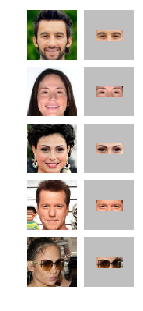

In [9]:
images = []
for i in data:
    images.append(i[0])
    images.append(i[0]*i[1]+0.5*(1-i[1]))
show_faces_masks(images, 5, 2, save=False)

In [10]:
DATA_OF_INTEREST = 2

In [11]:
def plotquery(images, name="Unknown", save=True, folder='canvas'):
    row = 2
    col = 2
    num_images = row*col
    names = ['(x,y)','y', '','x']
    fig = plt.figure(figsize=(col*2.5, row*2.5))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(row, col),
                     axes_pad=0.5)
    for i in xrange(num_images):
        im = images[i].reshape(64, 64, 3)
        im = (im + 1.)/2.
        axis = grid[i]
        axis.axis('off')
        if i != 2:
            axis.imshow(im)
            axis.set_title(names[i], fontsize=20)
    plt.axis('off')
    plt.tight_layout()
    if save:
        fig.savefig('figs/{0}/{1}.pdf'.format(folder, name), bbox_inches="tight", pad_inches=0, format='pdf')
    else:
        plt.show()

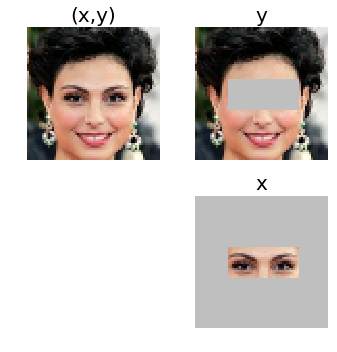

In [12]:
images = []

images.append(data[DATA_OF_INTEREST][0])
images.append(data[DATA_OF_INTEREST][0]*(1-data[DATA_OF_INTEREST][1])+0.5*data[DATA_OF_INTEREST][1])
images.append(np.ones(12288))
images.append(data[DATA_OF_INTEREST][0]*data[DATA_OF_INTEREST][1]+0.5*(1-data[DATA_OF_INTEREST][1]))
plotquery(images, save=False, name='query_celebA', folder='samples')

## Generator

In [13]:
class GENERATOR(object):
    def __init__(self, latent_dim, observation_dim, generator,
                 obs_distrib="Bernoulli",
                 obs_std=0.01,
                 ):

        self._latent_dim = latent_dim
        self._observation_dim = observation_dim
        self._generator = generator
        self._obs_distrib = obs_distrib
        self._obs_std = obs_std
        self._p_distribution = self._multivariate_normal()
        self._build_graph()

    def _multivariate_normal(self):
        return Normal([0.] * self._latent_dim, [1.] * self._latent_dim)

    def _build_graph(self):

        # placeholder for the input noise
        self.candid = tf.placeholder(tf.float32, shape=[None, self._latent_dim], name='candidate')

        self.partialx = tf.placeholder(tf.float32, shape=[None, self._observation_dim], name='partialx')
        self.mask = tf.placeholder(tf.float32, shape=[self._observation_dim], name='mask')

        # decode batch
        with tf.variable_scope('generator'):
            self.generated, self.network = self._generator(self.candid, False)

        if self._obs_distrib == "Gaussian":
            with tf.variable_scope('gaussian'):
                log_like = self._gaussian_log_likelihood(self.partialx * self.mask,
                                                         self.generated * self.mask,
                                                         self._obs_std)
        else:
            with tf.variable_scope('bernoulli'):
                log_like = self._bernoulli_log_likelihood(self.partialx * self.mask,
                                                          self.generated * self.mask)

        self.log_like = log_like - tf.reduce_sum(tf.log(self._p_distribution.prob(self.candid)), axis=1)
        self.probs = tf.exp(-self.log_like)

        with tf.variable_scope('gradient'):
            self.gradient = tf.gradients(tf.reduce_sum(self.log_like), self.candid)

        self._sesh = tf.Session()
        init = tf.global_variables_initializer()
        self._sesh.run(init)

    def load_pretrained(self, path):
        tl.files.load_and_assign_npz(sess=self._sesh, name=path, network=self.network)

    def e2x(self, noise):
        x = self._sesh.run(self.generated,
                           feed_dict={self.candid: noise})
        return x

    @staticmethod
    def _gaussian_log_likelihood(targets, mean, std):
        se = 0.5 * tf.reduce_sum(tf.square(targets - mean), axis=1) / (2 * tf.square(std))
        return se

    @staticmethod
    def _bernoulli_log_likelihood(targets, outputs, eps=1e-8):
        log_like = -tf.reduce_sum(targets * tf.log(outputs + eps)
                                  + (1. - targets) * tf.log((1. - outputs) + eps), axis=1)
        return log_like

    def get_density(self, candid, partialx, mask):
        density = self._sesh.run(self.probs,
                                 feed_dict={self.candid: candid, self.partialx: partialx, self.mask: mask})
        return density

    def get_log_density(self, candid, partialx, mask):
        log_like = self._sesh.run(self.log_like,
                                  feed_dict={self.candid: candid, self.partialx: partialx, self.mask: mask})
        return log_like

    def get_gradient(self, candid, partialx, mask):
        gradient = self._sesh.run(self.gradient,
                                  feed_dict={self.candid: candid, self.partialx: partialx, self.mask: mask})
        return np.asarray(gradient)[0]

    def save_generator(self, path, prefix="vi/"):
        variables = tf.trainable_variables()
        var_dict = {}
        for v in variables:
            if "generator" in v.name:
                name = prefix+v.name
                name = re.sub(":0", "", name)
                var_dict[name] = v
        for k, v in var_dict.items():
            print(k)
            print(v)
        saver = tf.train.Saver(var_dict)
        saver.save(self._sesh, path)

In [14]:
tf.reset_default_graph()
g = GENERATOR(LATENT_DIM, OBS_DIM, DECODER, obs_distrib='Gaussian')
g.load_pretrained(WEIGHTS)

Instructions for updating:
TensorLayer relies on TensorFlow to check name reusing.


[TL] this method is DEPRECATED and has no effect, please remove it from your code.
[TL] InputLayer  generator/generator/g/in: (?, 100)
[TL] DenseLayer  generator/generator/g/h0/lin: 4096 identity
[TL] ReshapeLayer generator/generator/g/h0/reshape: (?, 4, 4, 256)
[TL] BatchNormLayer generator/generator/g/h0/batch_norm: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:False
[TL] UpSampling2dLayer g/h1/upsample2d: is_scale:False size:[8, 8] method:1 align_corners:False
[TL] Conv2dLayer generator/generator/g/h1/conv2d: shape:(3, 3, 256, 128) strides:(1, 1, 1, 1) pad:SAME act:identity
[TL] BatchNormLayer generator/generator/g/h1/batch_norm: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:False
[TL] UpSampling2dLayer g/h2/upsample2d: is_scale:False size:[16, 16] method:1 align_corners:False
[TL] Conv2dLayer generator/generator/g/h2/conv2d: shape:(3, 3, 128, 64) strides:(1, 1, 1, 1) pad:SAME act:identity
[TL] BatchNormLayer generator/generator/g/h2/batch_norm: decay:0.900000 epsilo

In [15]:
g.save_generator('weights/generator.tensorflow')

vi/generator/generator/g/h3/conv2d/b_conv2d
<tf.Variable 'generator/generator/g/h3/conv2d/b_conv2d:0' shape=(32,) dtype=float32_ref>
vi/generator/generator/g/h3/conv2d/W_conv2d
<tf.Variable 'generator/generator/g/h3/conv2d/W_conv2d:0' shape=(3, 3, 64, 32) dtype=float32_ref>
vi/generator/generator/g/h0/lin/b
<tf.Variable 'generator/generator/g/h0/lin/b:0' shape=(4096,) dtype=float32_ref>
vi/generator/generator/g/h4/conv2d/W_conv2d
<tf.Variable 'generator/generator/g/h4/conv2d/W_conv2d:0' shape=(3, 3, 32, 3) dtype=float32_ref>
vi/generator/generator/g/h2/conv2d/W_conv2d
<tf.Variable 'generator/generator/g/h2/conv2d/W_conv2d:0' shape=(3, 3, 128, 64) dtype=float32_ref>
vi/generator/generator/g/h1/conv2d/W_conv2d
<tf.Variable 'generator/generator/g/h1/conv2d/W_conv2d:0' shape=(3, 3, 256, 128) dtype=float32_ref>
vi/generator/generator/g/h1/conv2d/b_conv2d
<tf.Variable 'generator/generator/g/h1/conv2d/b_conv2d:0' shape=(128,) dtype=float32_ref>
vi/generator/generator/g/h4/conv2d/b_conv2d
<tf.

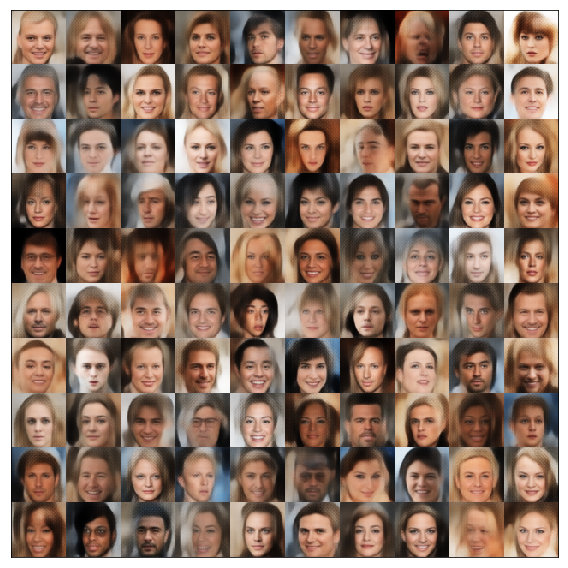

In [16]:
show_faces(g, 100, LATENT_DIM, "face_sample", n=10, save=False)

## Reject Sampling

In [17]:
class RejectionSampling(object):
    def __init__(self, generator, evidence, mask, batch_size, latent_dim):
        self.generator = generator
        self.evidence = evidence
        self.mask = mask
        self.dim = latent_dim
        self.batch_size = batch_size
        self.M = self.compute_M()
        
    def compute_M(self):
        
        M_candidate = []
        for i in range(1000):
            x = np.random.normal(0, 1, size=[100, self.dim])
            # px will be always 0 since the large search dimensions, so reject sampling fail
            px = self.generator.get_density(x, self.evidence, self.mask)
            qx = multivariate_normal.pdf(x, mean=[0]*self.dim, cov=np.eye(self.dim))
            M_candidate.append(max(px/qx))
        return max(M_candidate)
        
    def sampler(self):
        x = np.random.normal(0, 1, size=[self.batch_size, self.dim])
        px = self.generator.get_density(x, self.evidence, self.mask)
        qx = multivariate_normal.pdf(x, mean=[0]*self.dim, cov=np.eye(self.dim))
        
        rate = np.random.random_sample(size=self.batch_size)
        cond = rate < px/(qx*self.M)
        accepted_x = np.array([xv for (c,xv) in zip(cond,x) if c])
        
        violation = px/(qx*self.M) > 1
        
        return accepted_x, cond, violation
    
    def gather_samples(self, size):
        accept = []
        violation = []
        samples = []
        
        for i in tqdm(range(size)):
            q, accept_rate, violation_rate = self.sampler()
            samples.append(q)
            accept.append(accept_rate)
            violation.append(violation_rate)

        return np.vstack(samples), np.average(accept), np.average(violation)

In [18]:
rs = RejectionSampling(g, np.repeat([data[DATA_OF_INTEREST][0]], 1, axis=0), data[DATA_OF_INTEREST][1], 100, 100)

In [19]:
print(rs.M)

0.0


### Conclusion: Reject Sampling does not work on 128 latent dimensions

## HMC

In [20]:
class HMC(object):
    def __init__(self, generator, evidence, mask, batch_size, latent_dim):
        self.generator = generator
        self.evidence = evidence
        self.mask = mask
        self.batch_size = batch_size
        self.latent_dim = latent_dim

    def sampler(self, current_q, L=10, epsilon=0.01):
        q = current_q
        p = np.random.normal(0, 1, size=[self.batch_size, self.latent_dim])
        current_p = p

        p = p - epsilon * self.generator.get_gradient(q, self.evidence, self.mask)/2

        for l in range(L):
            q = q + epsilon * p[0]
            if l != L - 1:
                p = p - epsilon * self.generator.get_gradient(q, self.evidence, self.mask)
        p = p - epsilon * self.generator.get_gradient(q, self.evidence, self.mask)/2
        p = -p
        current_U = self.generator.get_log_density(current_q, self.evidence, self.mask)
        current_K = np.sum(np.square(current_p), axis=1) / 2

        proposed_U = self.generator.get_log_density(q, self.evidence, self.mask)
        proposed_K = np.sum(np.square(p), axis=1) / 2

        rate = np.random.random_sample(size=self.batch_size)
        cond = rate < np.exp(current_U-proposed_U+current_K-proposed_K)
        pos = np.concatenate((q, np.array([proposed_U]).T), axis=1)
        neg = np.concatenate((current_q, np.array([current_U]).T), axis=1)
        q_U = np.array([xv if c else yv for (c,xv,yv) in zip(cond,pos,neg)])
        precentage = sum(cond)/float(len(cond))
        return q_U[:, :-1], precentage#q_U[:, -1]

    def gather_samples(self, size, burn_in=5, L=35, epsilon=0.01):
        q = np.random.normal(0, 1, size=[self.batch_size, self.latent_dim])
        precentages = []

        for i in tqdm(range(burn_in)):
            q, _ = self.sampler(q, L, epsilon)

        # Gather samples
        samples = []
        for i in tqdm(range(size)):
            q, precentage = self.sampler(q, L, epsilon)
            samples.append(q)
            precentages.append(precentage)

        return np.vstack(samples), np.average(precentages)

In [21]:
hmc = HMC(g, np.repeat([data[DATA_OF_INTEREST][0]], 1, axis=0), data[DATA_OF_INTEREST][1], 1, LATENT_DIM)

In [22]:
zs, accept_rate = hmc.gather_samples(100, burn_in=10000, L=10, epsilon=0.001)
model_comparison['HMC'] = [zs, accept_rate]

100%|██████████| 100/100 [00:02<00:00, 43.35it/s]


In [23]:
accept_rate

0.94

In [24]:
zs.shape

(100, 100)

In [25]:
images = g.e2x(zs)
images = images*(1-data[DATA_OF_INTEREST][1]) + data[DATA_OF_INTEREST][0]*data[DATA_OF_INTEREST][1]

### HMC samples

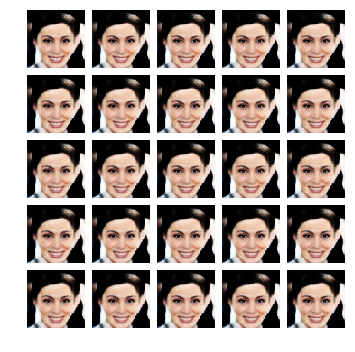

In [26]:
show_faces_masks(images, 5, 5, save=False, name='HMC', folder='samples')

# Variational Inference

In [27]:
import tensorflow as tf
from utils.jacobian import get_determinant, get_jacobian
from utils.codings import planar_projector, fc_noise_projector
import numpy as np
from tensorflow.contrib.distributions import Normal
from collections import defaultdict
from tqdm import tqdm
tqdm.monitor_interval = 0

In [28]:
class VariationalInference(object):
    def __init__(self, latent_dim, obs_dim, generator,
                 num_layer=1,
                 sklearn=True,
                 optimizer=tf.train.RMSPropOptimizer,
                 learning_rate=1e-3,
                 obs_distrib="Bernoulli",
                 obs_std=0.01,
                 ):
        """
        """
        self._latent_dim = latent_dim
        self._obs_dim = obs_dim
        self._generator = generator
        self._num_layer = num_layer
        self._sklearn = sklearn
        self._optimizer = optimizer
        self._learning_rate = learning_rate
        self._obs_distrib = obs_distrib
        self._obs_std = obs_std
        self._p_distribution = self._multivariate_normal()
        self._build_graph()
        self._build_optimizer()
        self._sesh = tf.Session()
        init = tf.global_variables_initializer()
        self._sesh.run(init)
        self.history = {'kl': [], 'sample': [], 'mmd': [], 'loglike': [], 'logdet': []}

    def get_name(self):
        pass

    def _multivariate_normal(self):
        return Normal([0.] * self._latent_dim, [1.] * self._latent_dim)

    def _build_graph(self):
        pass

    def _build_optimizer(self):
        with tf.variable_scope('optimizer'):
            if self._sklearn:
                self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss=self._loss,
                                                                        method='L-BFGS-B',
                                                                        var_list=self.trainable_variables,
                                                                        options={'maxiter': 10000})
            else:
                optimizer = self._optimizer(learning_rate=self._learning_rate)
                self.optimizer = optimizer.minimize(self._loss, var_list=self.trainable_variables)

    def load_pretrained(self, path):
        tl.files.load_and_assign_npz(sess=self._sesh, name=path, network=self.network)

    @staticmethod
    def _gaussian_log_likelihood(targets, mean, std):
        se = 0.5 * tf.reduce_sum(tf.square(targets - mean), axis=1) / (2 * tf.square(std))
        return se

    @staticmethod
    def _bernoulli_log_likelihood(targets, outputs, eps=1e-8):
        log_like = -tf.reduce_sum(targets * tf.log(outputs + eps)
                                  + (1. - targets) * tf.log((1. - outputs) + eps), axis=1)
        return log_like

    def call_back(self, loss, sample, loglike, logdet):
        self.history['kl'].append(loss)
        self.history['sample'].append(sample)
        self.history['loglike'].append(np.mean(loglike))
        self.history['logdet'].append(np.mean(logdet))

    def update(self, noise, partialx, mask, iteration=10000):
        if self._sklearn:
            try:
                self.optimizer.minimize(session=self._sesh,
                                        feed_dict={self.noise: noise, self.partialx: partialx, self.mask: mask},
                                        loss_callback=self.call_back,
                                        fetches=[self._loss, self.projected, self.log_like, self.logdet]
                                        )
            except Exception as e:
                print(e)

        else:
            previous_loss = None
            tbar = tqdm(range(iteration))
            for i in tbar:
                try:
                    _, loss, sample, loglike, logdet = self._sesh.run([self.optimizer,
                                                                       self._loss,
                                                                       self.projected,
                                                                       self.log_like,
                                                                       self.logdet],
                                                                       feed_dict={self.noise: noise,
                                                                                  self.partialx: partialx,
                                                                                  self.mask: mask}
                                                                      )
                    self.call_back(loss, sample, loglike, logdet)
                    # if previous_loss is not None:
                    #     if abs(loss-previous_loss)/max([abs(loss), abs(previous_loss), 1]) <= 10*np.finfo(float).eps:
                    #         break
                    s = "Loss: {:.4f}".format(loss)
                    tbar.set_description(s)

                    previous_loss = loss
                except Exception as e:
                    print(e)
                    break

    def e2z(self, noise):
        z = self._sesh.run(self.projected,
                           feed_dict={self.noise: noise})
        return z

    def e2x(self, noise):
        x = self._sesh.run(self.generated,
                           feed_dict={self.noise: noise})
        return x

    def get_history(self):
        return self.history

    def clean_history(self):
        self.history = defaultdict()

## Regular Variational Inference

In [29]:
class RegularVI(VariationalInference):

    def get_name(self):
        return "VI"

    def _build_graph(self):

        with tf.variable_scope('is'):
            self.noise = tf.placeholder(tf.float32, shape=[None, self._latent_dim])
            self.partialx = tf.placeholder(tf.float32, shape=[None, self._obs_dim])
            self.mask = tf.placeholder(tf.float32, shape=[self._obs_dim])

            with tf.variable_scope('projector'):
                cov = tf.Variable(tf.eye(self._latent_dim))
                mu = tf.Variable(tf.zeros(self._latent_dim))
                self.projected = mu + tf.matmul(self.noise, cov)

            with tf.variable_scope('log-det'):
                determinant = get_determinant(get_jacobian(self.projected, self.noise))
                self.logdet = -tf.log(determinant)

            with tf.variable_scope('generator'):
                self.generated, self.network = self._generator(self.projected, False)

            if self._obs_distrib == "Gaussian":
                with tf.variable_scope('gaussian'):
                    log_like = self._gaussian_log_likelihood(self.partialx * self.mask,
                                                             self.generated * self.mask,
                                                             self._obs_std)
            else:
                with tf.variable_scope('bernoulli'):
                    log_like = self._bernoulli_log_likelihood(self.partialx * self.mask,
                                                              self.generated * self.mask)
            self.trainable_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "is/projector")
            self.log_like = log_like - tf.reduce_sum(tf.log(self._p_distribution.prob(self.projected)), axis=1)
            self.probs = tf.exp(-self.log_like)

            log_loss = self.log_like + self.logdet

            self._loss = tf.reduce_mean(log_loss)

In [30]:
tf.reset_default_graph()
noise = np.random.normal(size=[100, LATENT_DIM])
vi = RegularVI(LATENT_DIM, OBS_DIM, DECODER, obs_distrib='Gaussian')
vi.load_pretrained(WEIGHTS)
vi.update(noise, np.repeat([data[DATA_OF_INTEREST][0]], 100, axis=0), data[DATA_OF_INTEREST][1])

Instructions for updating:
TensorLayer relies on TensorFlow to check name reusing.


[TL] this method is DEPRECATED and has no effect, please remove it from your code.
[TL] InputLayer  is/generator/generator/g/in: (?, 100)
[TL] DenseLayer  is/generator/generator/g/h0/lin: 4096 identity
[TL] ReshapeLayer is/generator/generator/g/h0/reshape: (?, 4, 4, 256)
[TL] BatchNormLayer is/generator/generator/g/h0/batch_norm: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:False
[TL] UpSampling2dLayer g/h1/upsample2d: is_scale:False size:[8, 8] method:1 align_corners:False
[TL] Conv2dLayer is/generator/generator/g/h1/conv2d: shape:(3, 3, 256, 128) strides:(1, 1, 1, 1) pad:SAME act:identity
[TL] BatchNormLayer is/generator/generator/g/h1/batch_norm: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:False
[TL] UpSampling2dLayer g/h2/upsample2d: is_scale:False size:[16, 16] method:1 align_corners:False
[TL] Conv2dLayer is/generator/generator/g/h2/conv2d: shape:(3, 3, 128, 64) strides:(1, 1, 1, 1) pad:SAME act:identity
[TL] BatchNormLayer is/generator/generator/g/h2/batch_nor

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 38301.062500
  Number of iterations: 200
  Number of functions evaluations: 207


### Regular VI Samples

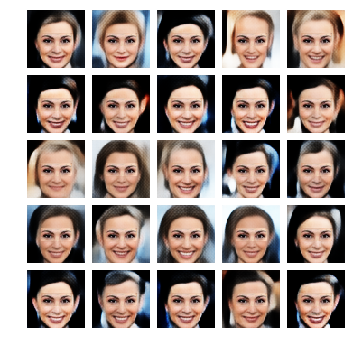

In [31]:
noise = np.random.normal(size=[100, LATENT_DIM])
images = vi.e2x(noise)
images = images*(1-data[DATA_OF_INTEREST][1]) + data[DATA_OF_INTEREST][0]*data[DATA_OF_INTEREST][1]
show_faces_masks(images, 5, 5, save=False, name='LGW', folder='samples')

In [32]:
model_comparison['VI'] = vi.history

## Normalizing Flow

In [33]:
class NormalizingFlowVI(VariationalInference):
    def get_name(self):
        return "NF"

    def _build_graph(self):

        with tf.variable_scope('is'):
            self.noise = tf.placeholder(tf.float32, shape=[None, self._latent_dim])
            self.partialx = tf.placeholder(tf.float32, shape=[None, self._obs_dim])
            self.mask = tf.placeholder(tf.float32, shape=[self._obs_dim])

            with tf.variable_scope('projector'):
                self.projected, self.logdet = planar_projector(self.noise, self._num_layer, self._latent_dim)

            self.trainable_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "is/projector")

            with tf.variable_scope('generator'):
                self.generated, self.network = self._generator(self.projected, False)

            if self._obs_distrib == "Gaussian":
                with tf.variable_scope('gaussian'):
                    log_like = self._gaussian_log_likelihood(self.partialx * self.mask,
                                                             self.generated * self.mask,
                                                             self._obs_std)
            else:
                with tf.variable_scope('bernoulli'):
                    log_like = self._bernoulli_log_likelihood(self.partialx * self.mask,
                                                              self.generated * self.mask)

            self.log_like = log_like - tf.reduce_sum(tf.log(self._p_distribution.prob(self.projected)), axis=1)
            self.probs = tf.exp(-self.log_like)

            log_loss = self.log_like + self.logdet

            self._loss = tf.reduce_mean(log_loss)

In [34]:
tf.reset_default_graph()
nf = NormalizingFlowVI(LATENT_DIM, OBS_DIM, DECODER, 32, obs_distrib='Gaussian')

Instructions for updating:
TensorLayer relies on TensorFlow to check name reusing.


[TL] this method is DEPRECATED and has no effect, please remove it from your code.
[TL] InputLayer  is/generator/generator/g/in: (?, 100)
[TL] DenseLayer  is/generator/generator/g/h0/lin: 4096 identity
[TL] ReshapeLayer is/generator/generator/g/h0/reshape: (?, 4, 4, 256)
[TL] BatchNormLayer is/generator/generator/g/h0/batch_norm: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:False
[TL] UpSampling2dLayer g/h1/upsample2d: is_scale:False size:[8, 8] method:1 align_corners:False
[TL] Conv2dLayer is/generator/generator/g/h1/conv2d: shape:(3, 3, 256, 128) strides:(1, 1, 1, 1) pad:SAME act:identity
[TL] BatchNormLayer is/generator/generator/g/h1/batch_norm: decay:0.900000 epsilon:0.000010 act:<lambda> is_train:False
[TL] UpSampling2dLayer g/h2/upsample2d: is_scale:False size:[16, 16] method:1 align_corners:False
[TL] Conv2dLayer is/generator/generator/g/h2/conv2d: shape:(3, 3, 128, 64) strides:(1, 1, 1, 1) pad:SAME act:identity
[TL] BatchNormLayer is/generator/generator/g/h2/batch_nor

In [35]:
nf.load_pretrained(WEIGHTS)

[TL] [*] Load weights/celebA/net.npz SUCCESS!


In [36]:
nf.update(noise, np.repeat([data[DATA_OF_INTEREST][0]], 100, axis=0), data[DATA_OF_INTEREST][1])

INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 77541.078125
  Number of iterations: 86
  Number of functions evaluations: 111


### Normalizing Flow Samples

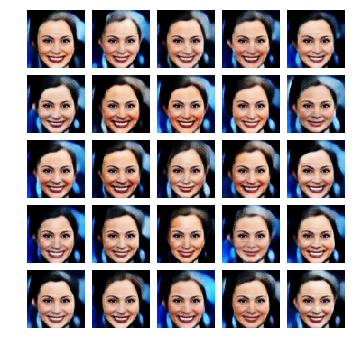

In [37]:
noise = np.random.normal(size=[100, LATENT_DIM])
images = nf.e2x(noise)
images = images*(1-data[DATA_OF_INTEREST][1]) + data[DATA_OF_INTEREST][0]*data[DATA_OF_INTEREST][1]
show_faces_masks(images, 5, 5, save=False, name='NF', folder='samples')

In [38]:
model_comparison['NF'] = nf.history